In [ ]:
# T6
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t6_8M_UR50D-finetuned-depolymerase.labels_4 \
/media/concha-eloko/Linux/depolymerase_building

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.T6.4Labels.1908.model \
/media/concha-eloko/Linux/depolymerase_building

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t6_8M_UR50D-finetuned-depolymerase.labels_3 \
/media/concha-eloko/Linux/depolymerase_building

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.T6.3Labels.1908.model \
/media/concha-eloko/Linux/depolymerase_building

# 12
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_3 \
/media/concha-eloko/Linux/depolymerase_building

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.T12.3Labels.1908.model \
/media/concha-eloko/Linux/depolymerase_building

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4 \
/media/concha-eloko/Linux/depolymerase_building

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/DepoDetection.T12.4Labels.1908.model \
/media/concha-eloko/Linux/depolymerase_building

In [13]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd 

import warnings
warnings.filterwarnings("ignore") 

#path_work = "/home/conchae/PhageDepo_pdb"
path_work = "/media/concha-eloko/Linux/depolymerase_building"

df_depo = pd.read_csv(f"{path_work}/Phagedepo.Dataset.2007.tsv" , sep = "\t" , header = 0)

df_beta_helix = df_depo[df_depo["Fold"] == "right-handed beta-helix"]
df_beta_prope = df_depo[df_depo["Fold"] == "6-bladed beta-propeller"]
df_beta_triple =  df_depo[df_depo["Fold"] == "triple-helix"]
df_negative = df_depo[df_depo["Fold"] == "Negative"]

/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df_negative

,Seq_ID,Fold,Prob,Boundaries,Full_seq
0,MF417929_00038,Negative,manual,Negative,MRQNRERKLAEKAVRLAQSPDPRLRKKKMSMGFDPGSPEGDYSATV...
1,MF417929_00041,Negative,manual,Negative,MNTPQPIQFDLMNPRQHGRILFAMGMSVSEIAKQIDEKRATVESWK...
2,MH616963_00015,Negative,manual,Negative,MAKDNYPFLDYINEDKSHYKTAASAGYKDDENLFLIGESGGFLMNI...
3,MH552500_00058,Negative,manual,Negative,MVKLEANVEEVINNYPFLNYINEDKSQYKTATNAGYDDPDNLFLIG...
4,BK010471_00079,Negative,manual,Negative,MADGKYPFLEYIEEPDKEKKYKKASDCGWYDPHNNFLIGDSGGFLL...
...,...,...,...,...,...
1404,OP820468_00017,Negative,manual,Negative,MSWPLNPAGTHYLFEGIVEIPVDPTAGAAILQLRPQGGIGVGVPAI...
1405,OP820468_00018,Negative,manual,Negative,MTSSFDPLPEWAHAVPSEPGIHPEQSALQWQRPFTVQQLLEIGEQF...
1406,OP820468_00019,Negative,manual,Negative,MTIKGYFVYAKEKDAPGDFVQLNPDPVLPPYGTNGLKSNTTYEFYV...
1407,OP820468_00020,Negative,manual,Negative,MSVAVGWWAESHVSFGVTITPEVGFRYGGPKQEFGVTLTPEIGMSA...


In [31]:
# T12
#esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_3/checkpoint-6015"
#DpoDetection_path = f"{path_work}/DepoDetection.T12.3Labels.1908.model"

esm2_model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
DpoDetection_path = f"{path_work}/DepoDetection.T12.4Labels.1908.model"

# T6
#esm2_model_path = f"{path_work}/esm2_t6_8M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
#DpoDetection_path = f"{path_work}/DepoDetection.T6.4Labels.1908.model"

#esm2_model_path = f"{path_work}/esm2_t6_8M_UR50D-finetuned-depolymerase.labels_3/checkpoint-6015"
#DpoDetection_path = f"{path_work}/DepoDetection.T6.3Labels.1908.model"

# T30
#esm2_model_path = f"{path_work}/script_files/esm2_t30_150M_UR50D-finetuned-depolymerase.labels_4/checkpoint-6015"
#DpoDetection_path = f"{path_work}/DepoDetection.T30.4Labels.1908.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


In [32]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 1)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs

model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-11): 12 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inpla

In [5]:
def predict_sequence(model, sequence):
    model.eval()
    with torch.no_grad():
        sequence = [sequence]  # Wrap the sequence in a list to match the model's input format
        outputs, sequence_outputs = model(sequence)
        probas = torch.sigmoid(outputs)  # Apply sigmoid activation for binary classification
        predictions = (probas > 0.5).float()  # Convert probabilities to binary predictions
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]
        prob_predicted = probas[0].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


In [6]:
def get_labels(df , label = 1) :
    labels_df = []
    for _,row in df.iterrows():
        info = row["Boundaries"]
        seq_length = len(row["Full_seq"])
        if info == "Negative" :
            labels = [label] * seq_length
            labels_df.append(labels)
        elif info == "full_protein" or info == "full" :
            labels = [label] * seq_length
            labels_df.append(labels)
        elif info.count(":") > 0 : 
            start = int(info.split(":")[0])
            end = int(info.split(":")[1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
        else :
            start = int(info.split("_")[-2])
            end = int(info.split("_")[-1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
    return labels_df



In [7]:
# ********************************************
# Transforming the data. Choose the label to associate with the triple helix :
# Beta-helix :
labels_beta_helix = get_labels(df_beta_helix , label = 1)
seq_beta_helix = df_beta_helix["Full_seq"].to_list()

# Beta propeller : 
labels_beta_propeller = get_labels(df_beta_prope , label = 2)
seq_beta_propeller = df_beta_prope["Full_seq"].to_list()

# Triple helix : 
labels_triple_helix = get_labels(df_beta_triple , label = 3)
seq_triple_helix = df_beta_triple["Full_seq"].to_list()

# Negative :
labels_negative = get_labels(df_negative , label = 0)
seq_negative = df_negative["Full_seq"].to_list()

# The input data :
sequences = seq_beta_helix + seq_beta_propeller + seq_triple_helix + seq_negative
labels = labels_beta_helix + labels_beta_propeller + labels_triple_helix + labels_negative

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state = 243)
train_esm2 , train_CNV , esm2_labels , CNV_labels = train_test_split(train_sequences, train_labels, test_size=0.125, random_state = 243)


> Make predictions on the test dataset :

In [33]:
predicted_labels = []
for _,seq in tqdm(enumerate(test_sequences)) : 
    _, sequence_outputs = predict_sequence(model_classifier, seq)
    predicted_labels.append(sequence_outputs)

458it [04:33,  1.67it/s]


> get right format : concatenate the test labels and the predicted labels then input it into the metric calculator

In [34]:
tmp_labels = tuple(zip(test_labels,predicted_labels))
final_test = []
final_pred = []

for _,label_tup in enumerate(tmp_labels) : 
    l = len(label_tup[0]) 
    if l > 1024 :
        final_test.append(label_tup[0][0:1024])
        final_pred.append(label_tup[1][0:1024])
    else : 
        final_test.append(label_tup[0][0:l])
        final_pred.append(label_tup[1][0:l])

# the big test label list
real_labels = []
for _,label_list in enumerate(final_test) : 
    real_labels = real_labels + label_list

# the big predicted label list
pred_labels = []
for _,label_list in enumerate(final_pred) : 
    pred_labels = pred_labels + label_list


In [35]:
len(real_labels) , len(pred_labels)

(233864, 233864)

In [36]:
f1 = f1_score(real_labels, pred_labels,average="weighted" )
precision = precision_score(real_labels, pred_labels,average="weighted")
recall = recall_score(real_labels, pred_labels,average="weighted" )  # Calculate recall
mcc = matthews_corrcoef(real_labels, pred_labels)  # Calculate MCC
accuracy = accuracy_score(real_labels, pred_labels)
cm = confusion_matrix(real_labels, pred_labels, normalize="true")

In [37]:
print(round(precision,5) , round(recall,5) , round(accuracy,5) , round(f1,5) , round(mcc,5), sep = "\t")

0.95957	0.95963	0.95963	0.95959	0.89837


In [38]:
cm

array([[0.97375687, 0.02110836, 0.00142316, 0.00371161],
       [0.09089484, 0.90910516, 0.        , 0.        ],
       [0.02721911, 0.        , 0.97278089, 0.        ],
       [0.08543438, 0.        , 0.        , 0.91456562]])

In [ ]:
with open(f"{path_work}/T30_eval.metrics.1808.txt", "w") as outfile : 
    outfile.write(f"F1 : {round(f1,5)},precision : {round(precision,5)},recall : {round(recall,5)},accuracy : {round(accuracy,5)},mcc : {round(mcc,5)},cm : {cm}")

In [ ]:
#!/bin/bash
#BATCH --job-name=big_pred__
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=10gb 
#SBATCH --time=0-01:00:00 
#SBATCH --output=big_pred__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/Metrics.T30.token_class.py


***
### Plot the confusion matrix : 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
path_figures = "/media/concha-eloko/Linux/PhageDEPOdetection/figures"


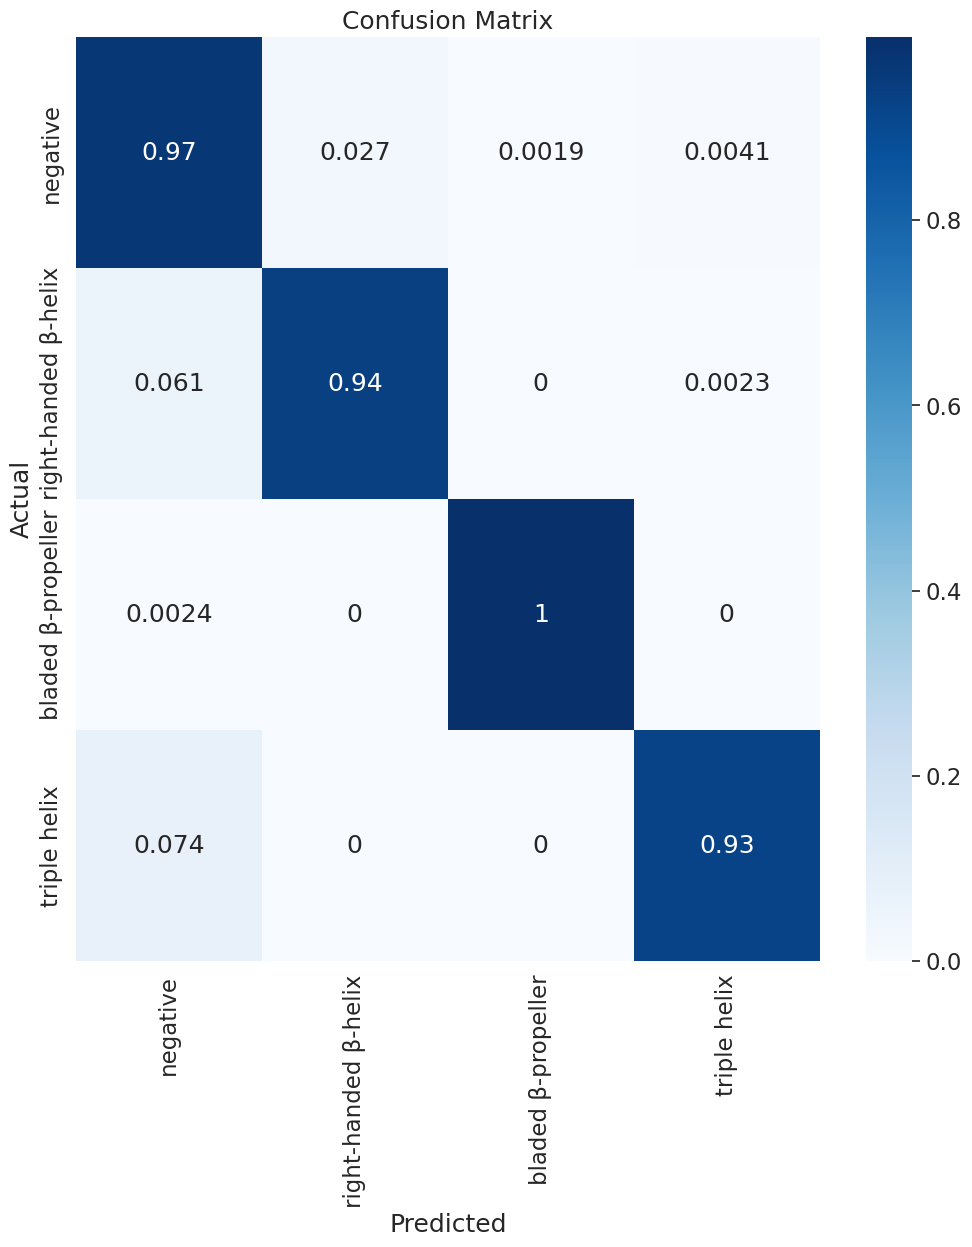

In [12]:
# Create a list of class labels for the x and y axes
class_labels = ['negative', 'right-handed β-helix',"bladed β-propeller","triple helix"]

confusion_matrix_T6 = [[0.97185552, 0.02242906, 0.00196966, 0.00374577],
[0.10169112, 0.89302273, 0.00528615, 0],
[0.06850144, 0, 0.93149856, 0],
[0.08183259, 0, 0, 0.91816741]]

confusion_matrix_T12 = [[0.97375687, 0.02110836, 0.00142316, 0.00371161],
 [0.09089484, 0.90910516, 0.        , 0.        ],
 [0.02721911, 0.        , 0.97278089, 0.        ],
 [0.08543438, 0.        , 0.        , 0.91456562]]

confusion_matrix_T30 = [[0.96663536, 0.02740443, 0.00190135, 0.00405886],
 [0.06126106, 0.93640945, 0.       ,  0.00232949],
 [0.00241948, 0.        , 0.99758052, 0.        ],
 [0.07434087, 0,         0,         0.92565913]]

# Create a Seaborn heatmap
sns.set(font_scale=1.5)  # Adjust font scale for better readability
plt.figure(figsize=(12, 12))  # Adjust the width and height as needed

sns.heatmap(confusion_matrix_T30, annot=True, cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{path_figures}/T30.confusion_matrix.svg', bbox_inches='tight')  # You can change the file format and name as needed
plt.show()
